# NLP Assignment PART 1: Text classification for Fake News Detection¶

## This assignment has solutions for Questions 1 to 4.

This coursework will involve you implementing functions for a text classifier, which you will train to detect fake news in a corpus of approx. 10,000 statements, which will be split into a 80%/20% training/test split.

In this template you are given the basis for that implementation, though some of the functions are missing, which you have to fill in.

Follow the instructions file NLP_Assignment_1_Instructions.pdf for details of each question - the outline of what needs to be achieved for each question is as below.

You must submit all ipython notebooks and extra resources you need to run the code if you've added them in the code submission, and a 2 page report (pdf) in the report submission on QMPlus where you report your methods and findings according to the instructions file for each question.

In [1]:
!pip install nltk


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Importing reuired modules

In [2]:
import csv    # csv reader
import re
import numpy as np
from sklearn import metrics
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

In [3]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path, encoding='utf-8') as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):
    """
    Split the data between train_data and test_data according to the percentage
    and performs the preprocessing.
    """
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)),label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))

# Question 1: Input and Basic preprocessing (10 marks)¶

In [4]:
def convert_label(label):
    """
    Converts the multiple classes into two,
    making it a binary distinction between fake news and real.
    """
    #return label
    # Converting the multiclass labels to binary label
    labels_map = {
        'true': 'REAL',
        'mostly-true': 'REAL',
        'half-true': 'REAL',
        'false': 'FAKE',
        'barely-true': 'FAKE',
        'pants-fire': 'FAKE'
    }
    return labels_map[label]

def parse_data_line(data_line):
    """
    This method get the label and statement columns from the given fake_news.tsv file.
    : param data_line: Row data from the given tsv file.
    : return: A tuple of label from the data and required columns from the data.
    """
    data_label = convert_label(data_line[1])
    statement =  data_line[2]
    return (data_label, statement)

In [5]:
def pre_process(text):
    """
    This method uses a count vectorizer to extract features from the given text. 
    For that, first, created a count vectorizer which by default does some pre-processing, 
    tokenizing and convert the words into lower case.
    :param text: a string of one statement
    : return tokens: list of words after performing data preprocessing and cleanup
    """
    count_vect = CountVectorizer()
    count_vect.fit_transform([text])
    tokens = count_vect.get_feature_names_out()
    return tokens

# Question 2: Basic Feature Extraction (20 marks)

In [6]:
global_feature = [] # A global list of features
def to_feature_vector(tokens):
    """
    This method returns a dictionary containing features as keys, and weights as values. 
    Add every new word in dictionary as a key and assign it value as 1. 
    If word already exists in dictionary then just increase its weight by 1.
    Also, maintains a list (global_feature) to get the all unique words in the given corpus.
    : param tokens: List of words
    : return feature_vector_dict: a dict = {'word': frequency} for given tokens
    """
    global_featureVector = {}
    for w in tokens:
        if w not in global_feature:
            global_feature.append(w)

        if w in global_featureVector:
            global_featureVector[w] += 1
        else:
            global_featureVector[w] = 1
    return global_featureVector

In [7]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC())])
    return SklearnClassifier(pipeline).train(data)

# Question 3: Cross-validation (20 marks)

In [8]:
def cross_validate(dataset, folds):
    """
    This method performs 10 folds cross validation on Train and test dataset
    : param dataset: Training Dataset (80% of total dataset)
    : param folds: Number of folds, 10
    :returns: 
    cv_results: Average of presicion, recall, fscore, accuracy of each fold
    first_fold_actual_label: list of First fold's Actual Label
    first_fold_predicted_label: list of First fold's Predicted Label
    """
    fold_size = int(len(dataset)/folds) + 1
    results = []

    for i in range(0, len(dataset), int(fold_size)):
        # trains and tests on the 10 folds of data in the dataset
        print("Fold start on items %d - %d" % (i, i+fold_size))
        test_data = dataset[i:i+fold_size]
        if i == 0:
            train_data = dataset[i+fold_size:]
        else:
            train_data = dataset[:i] + dataset[i+fold_size:]

        #Training classifier with train data
        classifier = train_classifier(train_data)
        actual_label = []
        predicted_label = []

        #Predicting label for each sample of test data and updating them in list above.
        for j in range(0, len(test_data)):
            actual_label.append(test_data[j][1])
            pred_label = predict_labels(test_data[j][0], classifier)
            predicted_label.append(pred_label[0])

        # Getting presicion, recall, fscore and accuracy
        presicion, recall, fscore, support = precision_recall_fscore_support(actual_label, predicted_label, average='weighted')
        accuracy = accuracy_score(actual_label, predicted_label)
        results.append([presicion, recall, fscore, accuracy])

        # Appening classification report of each fold in Classification_Report_for_Each_Fold_First_Notebook.txt file.
        with open("Classification_Report_for_Each_Fold_First_Notebook.txt", "a+") as f:
            f.write(f"\n =============Classification report for {i, i+fold_size} fold=======================")
            f.write(f"\n{classification_report(actual_label, predicted_label)}")
            f.write(f"\nConfusion matrix: \n {str(metrics.confusion_matrix(actual_label, predicted_label))}")

        # Getting fist fold's actual and predicted labels
        if i == 0:
            first_fold_actual_label = actual_label
            first_fold_predicted_label = predicted_label

    cv_result = [sum(val)/len(results) for val in zip(*results)]
    return cv_result, first_fold_actual_label, first_fold_predicted_label

In [9]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(preProcess(reviewSample)))

In [10]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'fake_news.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path)

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)



# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature), sep='\n')

Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 10241 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 10241 rawData, 8192 trainData, 2049 testData
Training Samples: 
8192
Features: 
12193


In [11]:
cv_results, first_fold_actual_label, first_fold_predicted_label = cross_validate(train_data, 10) # will work and output overall performance of p, r, f-score when cv implemented
print(f"\n\n Average Results of Presicion, Recall, Fscore, Accuracy of all folds: {cv_results}")

Fold start on items 0 - 820
Training Classifier...
Fold start on items 820 - 1640
Training Classifier...
Fold start on items 1640 - 2460
Training Classifier...
Fold start on items 2460 - 3280
Training Classifier...
Fold start on items 3280 - 4100
Training Classifier...
Fold start on items 4100 - 4920
Training Classifier...
Fold start on items 4920 - 5740
Training Classifier...
Fold start on items 5740 - 6560
Training Classifier...
Fold start on items 6560 - 7380
Training Classifier...
Fold start on items 7380 - 8200
Training Classifier...


 Average Results of Presicion, Recall, Fscore, Accuracy of all folds: [0.563313403250085, 0.5626558933077016, 0.5626790928460598, 0.5626558933077016]


# Question 4. Error Analysis (10 marks)¶

In [12]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

In [13]:
def get_false_positive_and_false_negative_data(train_data, first_fold_actual_label, first_fold_predicted_label, raw_data):
    """
    This method creates a new file to update all the False Positive and False Negative Data.
    For the first fold, all the predicted and actual labels which doesn't match will be written 
    into this file with the associated statement from raw_data. This file will help in analysing
    the actual confusions classifier is making while making the predictions.
    """
    fold_size = int(len(train_data)/10) + 1
    for i in range (0, fold_size):
        if first_fold_actual_label[i] != first_fold_predicted_label[i]:
            with open("False_Positives_And_False_Negatives_For_First_Fold.txt", "a+") as f:
                f.write(f"\n###Incorrect prediction of label for statement:")
                f.write(f"\n {str(raw_data[i])}")
                f.write(str(f"\n Predicted:{first_fold_predicted_label[i]}"))                

get_false_positive_and_false_negative_data(train_data, first_fold_actual_label, first_fold_predicted_label, raw_data)

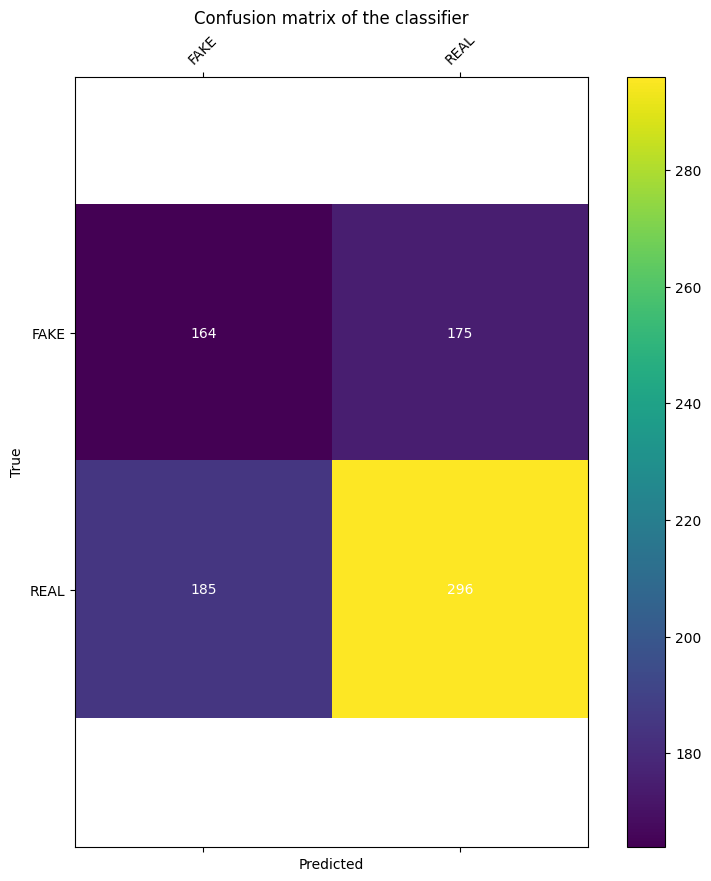


 Final Classification Report for first fold: 

               precision    recall  f1-score   support

        FAKE       0.47      0.48      0.48       339
        REAL       0.63      0.62      0.62       481

    accuracy                           0.56       820
   macro avg       0.55      0.55      0.55       820
weighted avg       0.56      0.56      0.56       820



In [14]:
labels = ['FAKE', 'REAL']
confusion_matrix_heatmap(first_fold_actual_label, first_fold_predicted_label, labels)

report = classification_report(first_fold_actual_label, first_fold_predicted_label)
print(f"\n Final Classification Report for first fold: \n\n {report}")

with open("Classification_Report_for_Each_Fold_First_Notebook.txt", "a+") as f:
    f.write(f"\n ============Classification Report for First Fold==============\n")
    f.write(f"\n\n{report}")